# RB1 and MCM

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re

import cptac
import cptac.utils as u

In [2]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


## Step 2: Find the mutation frequency of the gene of interest

In [3]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'RB1'

# Proteomics

In [4]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
omics_gene_list = ['MCM2','MCM3','MCM6']
prot_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = omics_gene_list) # single col level

In [5]:
# Step 2 - Create the binary column needed to do the comparison
prot_and_mut['RB1_mutation_status'] = prot_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
mut_wt = prot_and_mut.loc[prot_and_mut['Sample_Status'] == 'Tumor']
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_prot = mut_wt.drop(columns_to_drop, axis = 1)

In [6]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
prot_col_list = list(binary_prot.columns).remove('RB1_mutation_status')

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
prot_pval_results = u.wrap_ttest(binary_prot, 'RB1_mutation_status', prot_col_list,verbose=True)
prot_pval_results

Doing t-test comparison for mutation status
MCM2_proteomics :  0.0004843042653625298
MCM3_proteomics :  0.0009823912551144478
MCM6_proteomics :  0.00043663742812360517
3 significant comparisons!


,Comparison,P_Value
0,MCM6_proteomics,0.000437
1,MCM2_proteomics,0.000484
2,MCM3_proteomics,0.000982


In [7]:
binary_prot_melted = binary_prot.melt(id_vars='RB1_mutation_status')
binary_prot_melted

,RB1_mutation_status,Name,value
0,Mutated,MCM2_proteomics,0.865204
1,Mutated,MCM2_proteomics,0.943165
2,Wildtype,MCM2_proteomics,-0.236399
3,Mutated,MCM2_proteomics,-0.093372
4,Wildtype,MCM2_proteomics,-0.957693
...,...,...,...
292,Wildtype,MCM6_proteomics,0.440672
293,Wildtype,MCM6_proteomics,1.348624
294,Wildtype,MCM6_proteomics,-0.345955
295,Wildtype,MCM6_proteomics,-0.474821


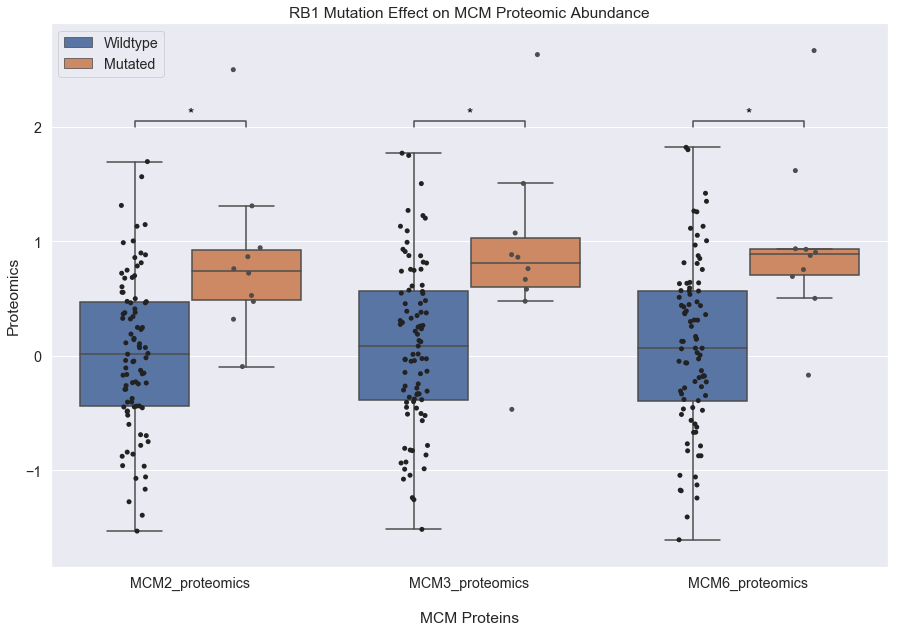

In [11]:
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='Name', y="value", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = binary_prot_melted, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Proteomic Abundance")
boxplot = sns.stripplot(x='Name', y="value", hue = 'RB1_mutation_status', data = binary_prot_melted, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Proteomics')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation= 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

format_pval_annotation('*',-.2, .2, 2)
format_pval_annotation('*',.8, 1.2, 2)
format_pval_annotation('*',1.8, 2.2, 2)

plt.show()
plt.clf()
plt.close()

# Phosphopoteomics MCM

In [23]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = ['MCM2','MCM3','MCM6'])
flatten_phospho_and_mut = brain.reduce_multiindex(phos, levels_to_drop=['Database_ID'], flatten=True)

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['RB1_mutation_status'] = flatten_phospho_and_mut['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else('Normal' if x == 'Wildtype_Normal' else 'Mutated'))

# Step 3 - Format
mut_wt = flatten_phospho_and_mut.loc[flatten_phospho_and_mut['Sample_Status'] == 'Tumor'] # drop normal
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = mut_wt.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('RB1_mutation_status', axis = 1)

# keep dataframe formatted to graph with normal samples
phospho_normal = flatten_phospho_and_mut.drop(columns_to_drop, axis = 1) # includes normal samples 
only_phospho

Name,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QR,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QREAAER,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK,MCM2_phosphoproteomics_S139_RGLLYDS*DEEDEERPAR,MCM2_phosphoproteomics_S139_RGLLYDS*DEEDEERPARK,MCM2_phosphoproteomics_S26S27_GNDPLTS*S*PGR,MCM2_phosphoproteomics_S27_GNDPLTSS*PGR,MCM2_phosphoproteomics_S27_RGNDPLTSS*PGR,MCM2_phosphoproteomics_S27S31_GNDPLTSS*PGRS*SR,...,MCM3_phosphoproteomics_T719S726_RSEDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_T758_DGDSYDPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_T767_DGDSYDPYDFSDTEEEMPQVHT*PK,MCM3_phosphoproteomics_Y750T758_DGDSY*DPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_Y750T758T767_DGDSY*DPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_Y753S756_DGDSYDPY*DFS*DTEEEMPQVHTPK,MCM3_phosphoproteomics_Y753T758_DGDSYDPY*DFSDT*EEEMPQVHTPK,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,0.250213,0.469123,0.553357,1.007214,0.116577,NaN,NaN,0.526739,NaN,NaN,...,0.678117,0.404877,0.760381,1.263384,-0.027740,0.738357,NaN,NaN,1.420706,1.877255
S002,0.680272,NaN,0.592142,1.128073,NaN,NaN,NaN,NaN,0.940525,NaN,...,NaN,NaN,1.179724,NaN,1.487462,0.919016,NaN,NaN,NaN,1.948601
S003,-1.100628,1.074279,-0.417157,-0.105052,NaN,NaN,NaN,-0.412701,-0.455602,NaN,...,NaN,-0.544556,NaN,0.523043,-0.490306,-0.500680,NaN,NaN,NaN,-1.433919
S004,NaN,0.539857,NaN,0.118192,1.192966,NaN,NaN,-0.194149,-0.680688,NaN,...,NaN,-0.870803,0.144140,-0.125183,NaN,0.060158,NaN,NaN,NaN,1.810520
S005,-1.149843,-1.269670,-1.141344,-0.707192,-0.493904,NaN,NaN,-0.524123,NaN,NaN,...,-0.069588,-1.647757,-0.782928,-0.504335,-1.203474,-1.139279,NaN,NaN,-0.856215,-0.940915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,NaN,NaN,0.359011,0.418889,NaN,NaN,-0.029957,0.174771,0.214947,NaN,...,NaN,0.365978,0.192255,NaN,1.119711,-0.397695,NaN,NaN,NaN,0.071564
S101,0.632754,0.893717,0.691414,1.109485,0.900207,NaN,NaN,0.609089,NaN,NaN,...,NaN,NaN,1.224494,NaN,NaN,NaN,NaN,0.54111,-0.041491,-0.930436
S102,-0.349986,-0.093704,-0.576220,-0.328765,-0.119699,NaN,NaN,NaN,-0.244054,NaN,...,NaN,-0.670114,-0.765056,0.084825,-0.451585,-0.461740,-0.172133,NaN,-0.338995,-0.099489


In [14]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'RB1_mutation_status', phos_col_list)
phos_pval_results

Doing t-test comparison for mutation status
11 significant comparisons!


,Comparison,P_Value
0,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK_...,9.811491e-08
1,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVY...,2.610996e-07
2,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT...,2.761099e-05
3,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEE...,9.685043e-05
4,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK_N...,9.706725e-05
5,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*E...,1.171451e-04
6,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDE...,1.244903e-04
7,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR_...,3.395965e-04
8,MCM3_phosphoproteomics_S717T719S726_RSEDES*ET*...,6.866016e-04
9,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK...,8.706963e-04


In [24]:
# Create data frame with all significant phospho sites in order to graph
#phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
phospho_list = list(only_phospho.columns)

phospho_df_RB1 = pd.melt(binary_phospho, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_RB1

,RB1_mutation_status,specific_phospho,phosphoproteomics
0,Mutated,MCM2_S108,0.250213
1,Mutated,MCM2_S108,0.680272
2,Wildtype,MCM2_S108,-1.100628
3,Mutated,MCM2_S108,NaN
4,Wildtype,MCM2_S108,-1.149843
...,...,...,...
4846,Wildtype,MCM6_S762,0.071564
4847,Wildtype,MCM6_S762,-0.930436
4848,Wildtype,MCM6_S762,-0.099489
4849,Wildtype,MCM6_S762,-1.646106


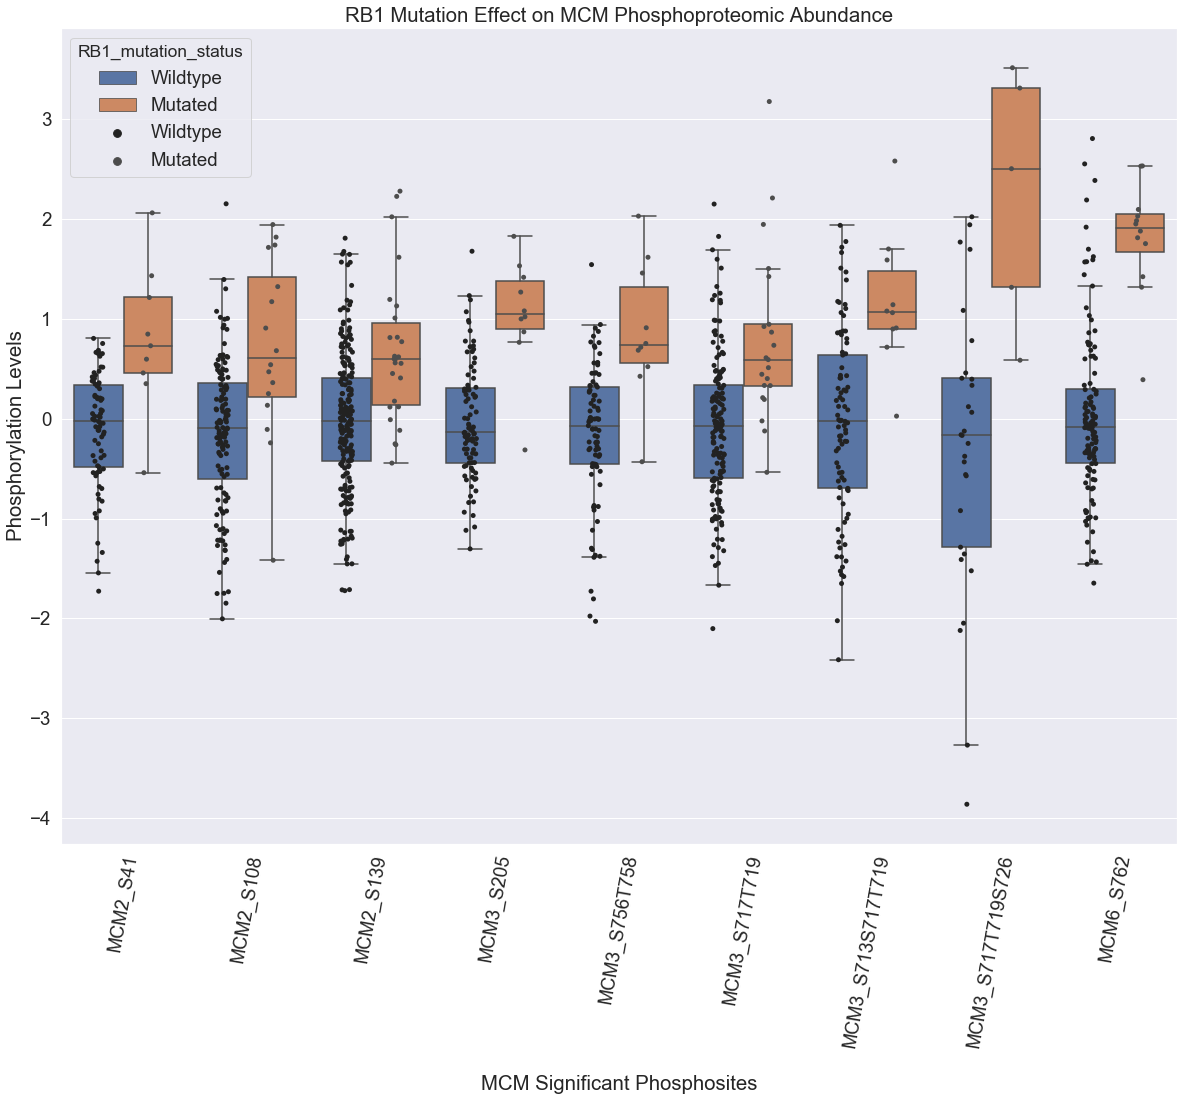

In [25]:
# Visualize 
plt.rcParams['figure.figsize']=(20,15)#size of plot
sns.set(font_scale = 1.7)

#plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                          hue_order = ['Wildtype', 'Mutated'],
                          order = ['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'],
                          data = phospho_df_RB1, showfliers = False)    
boxplot.set_title("RB1 Mutation Effect on MCM Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_RB1, jitter = True, 
                           color = ".3",dodge = True, hue_order = ['Wildtype', 'Mutated'],
                           order=['MCM2_S41','MCM2_S108','MCM2_S139','MCM3_S205','MCM3_S756T758','MCM3_S717T719','MCM3_S713S717T719','MCM3_S717T719S726','MCM6_S762'])
boxplot.set(xlabel = "\nMCM Significant Phosphosites", ylabel = 'Phosphorylation Levels')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
#handles, labels = boxplot.get_legend_handles_labels()
#plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Normalize phopho

Data already is log transformed. To normalize Phosphoproteomics - Proteomics

MCM2

In [26]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM2')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM2_proteomics']]
mprot

Name,MCM2_proteomics
Sample_ID,
S001,0.865204
S002,0.943165
S003,-0.236399
S004,-0.093372
S005,-0.957693
...,...
S100,0.322572
S101,1.145468
S102,-0.438594


In [27]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM2')
flatten = brain.reduce_multiindex(phos, levels_to_drop=['Database_ID'], flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM2 = tumors.drop(columns_to_drop, axis = 1)
only_MCM2 = binary_MCM2.drop('RB1_mutation_status', axis = 1)

In [28]:
norm = pd.DataFrame()

for i, cols in only_MCM2.iteritems():
    norm[i] = cols - mprot['MCM2_proteomics']

MCM2_df = norm.join(binary_MCM2['RB1_mutation_status']) 

In [29]:
MCM2_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM2 phosphorylation")
MCM2_phos_pval_results = u.wrap_ttest(MCM2_df, 'RB1_mutation_status', MCM2_col_list)
MCM2_phos_pval_results

Doing t-test comparison for mutation status of RB1 on MCM2 phosphorylation
No significant comparisons.


MCM3

In [30]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM3')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM3_proteomics']]
mprot

Name,MCM3_proteomics
Sample_ID,
S001,1.072049
S002,0.860945
S003,-0.133899
S004,-0.466708
S005,-0.821546
...,...
S100,0.351698
S101,1.224041
S102,-0.331383


In [31]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM3')
flatten = brain.reduce_multiindex(phos, levels_to_drop=['Database_ID'], flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM3 = tumors.drop(columns_to_drop, axis = 1)
only_MCM3 = binary_MCM3.drop('RB1_mutation_status', axis = 1)
binary_MCM3['RB1_mutation_status']
only_MCM3

Name,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK,MCM3_phosphoproteomics_S713_KRS*EDESETEDEEEK,MCM3_phosphoproteomics_S713S717_KRS*EDES*ETEDEEEK,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK,MCM3_phosphoproteomics_S713T719_RS*EDESET*EDEEEK,MCM3_phosphoproteomics_S713T719S726_RS*EDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_S717_KRSEDES*ETEDEEEK,MCM3_phosphoproteomics_S717_RSEDES*ETEDEEEK,MCM3_phosphoproteomics_S717T719_KRSEDES*ET*EDEEEK,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK,...,MCM3_phosphoproteomics_T719_KRSEDESET*EDEEEK,MCM3_phosphoproteomics_T719_RSEDESET*EDEEEK,MCM3_phosphoproteomics_T719S726_RSEDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_T758_DGDSYDPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_T767_DGDSYDPYDFSDTEEEMPQVHT*PK,MCM3_phosphoproteomics_Y750T758_DGDSY*DPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_Y750T758T767_DGDSY*DPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_Y753S756_DGDSYDPY*DFS*DTEEEMPQVHTPK,MCM3_phosphoproteomics_Y753T758_DGDSYDPY*DFSDT*EEEMPQVHTPK
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,1.078313,1.197712,0.636480,1.140307,NaN,NaN,NaN,0.789201,0.609024,0.944351,...,0.327950,1.059769,0.678117,0.404877,0.760381,1.263384,-0.027740,0.738357,NaN,NaN
S002,0.868698,0.520708,0.746420,1.587860,NaN,NaN,0.339036,0.394290,NaN,0.922311,...,NaN,NaN,NaN,NaN,1.179724,NaN,1.487462,0.919016,NaN,NaN
S003,0.281070,0.230958,-0.393435,-0.710630,-0.369789,NaN,NaN,-0.503656,NaN,-0.364562,...,NaN,NaN,NaN,-0.544556,NaN,0.523043,-0.490306,-0.500680,NaN,NaN
S004,-0.312857,-0.403621,-0.416728,0.025458,NaN,1.676289,NaN,-0.611863,NaN,-0.022558,...,NaN,-0.428378,NaN,-0.870803,0.144140,-0.125183,NaN,0.060158,NaN,NaN
S005,-0.478029,1.040704,-0.729764,-1.381473,NaN,NaN,NaN,-0.283311,-0.829937,-1.666821,...,-0.020151,-1.484511,-0.069588,-1.647757,-0.782928,-0.504335,-1.203474,-1.139279,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,0.776120,-3.360659,-0.567245,0.286548,NaN,NaN,NaN,-0.096263,NaN,0.397658,...,NaN,NaN,NaN,0.365978,0.192255,NaN,1.119711,-0.397695,NaN,NaN
S101,0.776362,0.300378,1.073278,1.467751,NaN,NaN,NaN,0.752803,1.506595,0.871357,...,NaN,0.439947,NaN,NaN,1.224494,NaN,NaN,NaN,NaN,0.54111
S102,-0.153918,-0.511331,-0.695425,-0.720057,NaN,NaN,NaN,-0.032070,NaN,-0.353364,...,NaN,-0.131417,NaN,-0.670114,-0.765056,0.084825,-0.451585,-0.461740,-0.172133,NaN


In [32]:
norm = pd.DataFrame()

for i, cols in only_MCM3.iteritems():
    norm[i] = cols - mprot['MCM3_proteomics']

MCM3_df = norm.join(binary_MCM3['RB1_mutation_status']) 
MCM3_df

,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK,MCM3_phosphoproteomics_S713_KRS*EDESETEDEEEK,MCM3_phosphoproteomics_S713S717_KRS*EDES*ETEDEEEK,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK,MCM3_phosphoproteomics_S713T719_RS*EDESET*EDEEEK,MCM3_phosphoproteomics_S713T719S726_RS*EDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_S717_KRSEDES*ETEDEEEK,MCM3_phosphoproteomics_S717_RSEDES*ETEDEEEK,MCM3_phosphoproteomics_S717T719_KRSEDES*ET*EDEEEK,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK,...,MCM3_phosphoproteomics_T719_RSEDESET*EDEEEK,MCM3_phosphoproteomics_T719S726_RSEDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_T758_DGDSYDPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_T767_DGDSYDPYDFSDTEEEMPQVHT*PK,MCM3_phosphoproteomics_Y750T758_DGDSY*DPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_Y750T758T767_DGDSY*DPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_Y753S756_DGDSYDPY*DFS*DTEEEMPQVHTPK,MCM3_phosphoproteomics_Y753T758_DGDSYDPY*DFSDT*EEEMPQVHTPK,RB1_mutation_status
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,0.006264,0.125663,-0.435570,0.068257,NaN,NaN,NaN,-0.282849,-0.463026,-0.127698,...,-0.012281,-0.393932,-0.667173,-0.311668,0.191334,-1.099790,-0.333692,NaN,NaN,Mutated
S002,0.007753,-0.340236,-0.114525,0.726916,NaN,NaN,-0.521909,-0.466654,NaN,0.061366,...,NaN,NaN,NaN,0.318780,NaN,0.626517,0.058071,NaN,NaN,Mutated
S003,0.414969,0.364858,-0.259536,-0.576731,-0.23589,NaN,NaN,-0.369757,NaN,-0.230663,...,NaN,NaN,-0.410657,NaN,0.656942,-0.356407,-0.366780,NaN,NaN,Wildtype
S004,0.153851,0.063087,0.049980,0.492166,NaN,2.142996,NaN,-0.145155,NaN,0.444150,...,0.038329,NaN,-0.404095,0.610847,0.341525,NaN,0.526866,NaN,NaN,Mutated
S005,0.343518,1.862250,0.091782,-0.559927,NaN,NaN,NaN,0.538235,-0.008390,-0.845275,...,-0.662965,0.751958,-0.826211,0.038618,0.317211,-0.381928,-0.317733,NaN,NaN,Wildtype
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,0.424422,-3.712357,-0.918943,-0.065150,NaN,NaN,NaN,-0.447961,NaN,0.045960,...,NaN,NaN,0.014280,-0.159443,NaN,0.768013,-0.749393,NaN,NaN,Wildtype
S101,-0.447680,-0.923663,-0.150763,0.243709,NaN,NaN,NaN,-0.471238,0.282554,-0.352685,...,-0.784094,NaN,NaN,0.000452,NaN,NaN,NaN,NaN,-0.682931,Wildtype
S102,0.177465,-0.179949,-0.364042,-0.388674,NaN,NaN,NaN,0.299313,NaN,-0.021982,...,0.199965,NaN,-0.338732,-0.433674,0.416208,-0.120202,-0.130357,0.159249,NaN,Wildtype


In [33]:
MCM3_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM3 phosphorylation")
MCM3_phos_pval_results = u.wrap_ttest(MCM3_df, 'RB1_mutation_status', MCM3_col_list)
MCM3_phos_pval_results

Doing t-test comparison for mutation status of RB1 on MCM3 phosphorylation
No significant comparisons.


MCM6

In [34]:
prot = brain.get_proteomics()
prot_mut = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'proteomics', omics_genes = 'MCM6')
prot_tumors = prot_mut.loc[prot_mut['Sample_Status'] == 'Tumor']
mprot = prot_tumors[['MCM6_proteomics']]
mprot

Name,MCM6_proteomics
Sample_ID,
S001,0.929678
S002,0.934636
S003,0.127075
S004,-0.167996
S005,-0.828283
...,...
S100,0.440672
S101,1.348624
S102,-0.345955


In [35]:
phos = brain.join_omics_to_mutations(
    mutations_genes = 'RB1', omics_df_name = 'phosphoproteomics', omics_genes = 'MCM6')
flatten = brain.reduce_multiindex(phos, levels_to_drop=['Database_ID'], flatten=True)

flatten['RB1_mutation_status'] = flatten['RB1_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

tumors = flatten.loc[flatten['Sample_Status'] == 'Tumor'] # drop normal

columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_MCM6 = tumors.drop(columns_to_drop, axis = 1)
only_MCM6 = binary_MCM6.drop('RB1_mutation_status', axis = 1)
binary_MCM6['RB1_mutation_status']
only_MCM6

Name,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK
Sample_ID,,
S001,1.420706,1.877255
S002,NaN,1.948601
S003,NaN,-1.433919
S004,NaN,1.810520
S005,-0.856215,-0.940915
...,...,...
S100,NaN,0.071564
S101,-0.041491,-0.930436
S102,-0.338995,-0.099489


In [36]:
norm = pd.DataFrame()

for i, cols in only_MCM6.iteritems():
    norm[i] = cols - mprot['MCM6_proteomics']

MCM6_df = norm.join(binary_MCM6['RB1_mutation_status']) 
MCM6_df

,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK,RB1_mutation_status
Sample_ID,,,
S001,0.491029,0.947577,Mutated
S002,NaN,1.013964,Mutated
S003,NaN,-1.560994,Wildtype
S004,NaN,1.978517,Mutated
S005,-0.027932,-0.112632,Wildtype
...,...,...,...
S100,NaN,-0.369108,Wildtype
S101,-1.390115,-2.279061,Wildtype
S102,0.006960,0.246466,Wildtype


In [39]:
MCM6_col_list = list(norm.columns)

# T-test
print("Doing t-test comparison for mutation status of RB1 on MCM6 phosphorylation")
MCM6_phos_pval_results = u.wrap_ttest(MCM6_df, 'RB1_mutation_status', MCM6_col_list)
MCM6_phos_pval_results

Doing t-test comparison for mutation status of RB1 on MCM6 phosphorylation
1 significant comparisons!


,Comparison,P_Value
0,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK,0.00002


In [44]:
sig = list(MCM6_phos_pval_results['Comparison'])
mcm = MCM6_df[sig].join(binary_MCM6['RB1_mutation_status'])
d = {'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK': "MCM6_S762"}
mcm = mcm.rename(columns = d)
mcm

,MCM6_S762,RB1_mutation_status
Sample_ID,,
S001,0.947577,Mutated
S002,1.013964,Mutated
S003,-1.560994,Wildtype
S004,1.978517,Mutated
S005,-0.112632,Wildtype
...,...,...
S100,-0.369108,Wildtype
S101,-2.279061,Wildtype
S102,0.246466,Wildtype


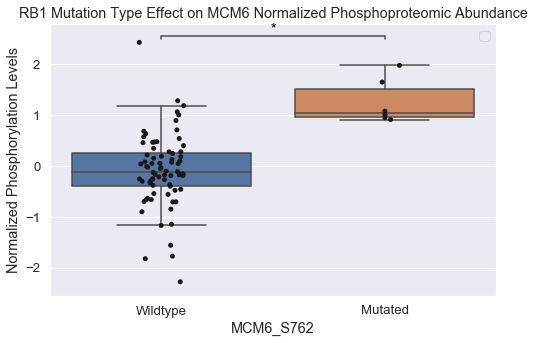

In [48]:
# Visualize NORMALIZED
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='RB1_mutation_status', y="MCM6_S762",
                         order = ['Wildtype', 'Mutated'], data = mcm, showfliers = False)    
boxplot.set_title("RB1 Mutation Type Effect on MCM6 Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='RB1_mutation_status', y="MCM6_S762", data = mcm, jitter = True, 
                           color = ".1", order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "MCM6_S762", ylabel = 'Normalized Phosphorylation Levels')

#boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

format_pval_annotation('*',0, 1, 2.5)

plt.show()
plt.clf()
plt.close()

In [42]:
# create csv file
mcm = mcm.reset_index()
mcm['Gene'] = 'MCM6'
d = {'Sample_ID': "Sample", 
     'MCM6_S762': "Value",
    'RB1_mutation_status':"Status"}
#mcm = mcm.rename(columns = d)
#mcm.to_csv("MCM6.csv")

In [49]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
MCM = only_MCM2.join(only_MCM3)
MCM = MCM.join(only_MCM6)
sig_mcm = MCM[phospho_list]
norm_mcm236 = sig_mcm.join(binary_MCM6['RB1_mutation_status']) 
norm_mcm236

KeyError: "None of [Index(['MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK_NP_005906.2',\n       'MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK_NP_002379.3',\n       'MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT*EEEMPQVHTPK_NP_002379.3',\n       'MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK_NP_002379.3',\n       'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK_NP_005906.2',\n       'MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK_NP_002379.3',\n       'MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QR_NP_004517.2',\n       'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR_NP_004517.2',\n       'MCM3_phosphoproteomics_S717T719S726_RSEDES*ET*EDEEEKS*QEDQEQK_NP_002379.3',\n       'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK_NP_004517.2',\n       'MCM2_phosphoproteomics_S41_RTDALTSS*PGR_NP_004517.2'],\n      dtype='object', name='Name')] are in the [columns]"

In [ ]:
phospho_df_MCM = pd.melt(norm_mcm236, id_vars = 'RB1_mutation_status', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM


In [ ]:
# Visualize NORMALIZED
plt.rcParams['figure.figsize']=(15,8) #size of plot
sns.set(font_scale = 1.3)

boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_MCM, showfliers = False)    
boxplot.set_title("RB1 Mutation Type effect on Normalized Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'RB1_mutation_status', data = phospho_df_MCM, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "\nMCM Proteins", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [ ]:
d = {'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK': "MCM6_S762", 
     'MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK': "MCM6_S762 2!",
     'MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK': "MCM3_S205",
     'MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT*EEEMPQVHTPK': "MCM3_S756T758",
     'MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK': "MCM3_S717T719",
     'MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK': "MCM3_S713S717T719",
     'MCM3_phosphoproteomics_S717T719S726_RSEDES*ET*EDEEEKS*QEDQEQK': "MCM3_S717T719S726",
     'MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAS*QR': "MCM2_S108",
     'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR': "MCM2_S139",
     'MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK': "MCM2_S139 2!",
     'MCM2_phosphoproteomics_S41_RTDALTSS*PGR': "MCM2_S41"}
sig2 = sig.rename(columns = d)
